In [1]:
# Libraries

import os
import platform
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux'   : ROOT = '/d/hpc/projects/FRI/up4472/upolanc-thesis'
		elif platform.system() == 'Windows' : ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else : raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		print()

		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.report import report_load
from source.python.report import report_concat
from source.python.report import report_filter
from source.python.report import report_plot
from source.python.io     import loader
from source.python.io     import writer
from source.python        import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

In [4]:
# List reports folder content

ROOT_DIR = os.path.join(ROOT, 'reports', '2023-06-13')

for index, name in enumerate(os.listdir(ROOT_DIR), start = 0) :
	path_l0 = os.path.join(ROOT_DIR, name)

	if index == 0 : print('{} :'.format(path_l0))
	else          : print('\n{} :'.format(path_l0))

	for name in os.listdir(path_l0) :
		print('...\\{}'.format(name))

	print()

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-13\regression-bert :
...\fc2-def-12-3-72-po0512-adam-f2-0250-global-mean
...\fc2-def-12-3-72-po0512-adam-f3-0250-global-mean


C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-13\regression-cnn-bert :
...\fex-fc3-3-f3-po0512-0250-72-global-mean
...\fex-fc3-3-f3-po4096-0250-72-global-mean
...\fex-fc3-3-f3-pu4096-0250-72-global-mean
...\fex-fc3-3-f3-tf2150-0250-72-global-mean
...\fex-fc3-6-f3-po0512-0250-72-global-mean
...\fex-fc3-6-f3-po4096-0250-72-global-mean
...\fex-fc3-6-f3-pu4096-0250-72-global-mean
...\fex-fc3-6-f3-tf2150-0250-72-global-mean


C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-13\regression-tuner-cnn :
...\zrimec-tf2150-f2-1000-25-72-global-mean
...\zrimec-tf2150-f3-1000-25-72-global-mean



In [5]:
# Load existing configurations

CONFIG_DIR = os.path.join(ROOT, 'resources', 'tuner')

ZCONFIG_PATH = os.path.join(CONFIG_DIR, 'zrimec.json')
WCONFIG_PATH = os.path.join(CONFIG_DIR, 'washburn.json')

ZCONFIG = list()
WCONFIG = list()

CONFIG_MAX       = 100
CONFIG_BEST      = 10
CONFIG_OVERWRITE = True
CONFIG_EXTEND    = False

if os.path.exists(ZCONFIG_PATH) and CONFIG_EXTEND :
	ZCONFIG = loader.load_json(filename = ZCONFIG_PATH)

	print('Sucessufully loaded configuration [{:88s}] with [{:2d}] elements'.format(ZCONFIG_PATH, len(ZCONFIG)))
	print()

if os.path.exists(WCONFIG_PATH) and CONFIG_EXTEND :
	WCONFIG = loader.load_json(filename = WCONFIG_PATH)

	print('Sucessufully loader configuration [{:88s}] with [{:2d}] elements'.format(WCONFIG_PATH, len(WCONFIG)))
	print()

# 1. Tuner

## 1.1 Model

In [6]:
# Load tune model reports

report_tune_model = report_load.load_cnn_tune_reports(
	root = ROOT_DIR,
	show = False,
	n    = 5
)

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-13\regression-tuner-cnn\zrimec-tf2150-f2-1000-25-72-global-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-13\regression-tuner-cnn\zrimec-tf2150-f3-1000-25-72-global-mean\report.csv


### 1.1.1 Regression

In [7]:
# Display overall regression prediction

R2_THRESHOLD = 0.00

for key, dataframe in report_tune_model['regression'].items() :
	nan_mse = dataframe['valid_loss'].isnull().values.ravel().sum()
	pos_r2  = dataframe[dataframe['valid_r2'] > R2_THRESHOLD]['valid_r2'].count()
	neg_r2  = dataframe[dataframe['valid_r2'] < R2_THRESHOLD]['valid_r2'].count()

	print('{:64s} : Size = {:4d} || NaN Loss = {:4d} || Pos R2 = {:4d} || Neg R2 = {:4d}'.format(key, len(dataframe), nan_mse, pos_r2, neg_r2))

print()

zrimec-tf2150-f2-1000-25-72-global-mean                          : Size = 1000 || NaN Loss =    0 || Pos R2 =  211 || Neg R2 =  789
zrimec-tf2150-f3-1000-25-72-global-mean                          : Size = 1000 || NaN Loss =    0 || Pos R2 =  201 || Neg R2 =  799



In [8]:
# Concat reports and display top few

report = report_concat.concat_cnn_tune_reports(
	reports = report_tune_model,
	mode    = 'regression',
	n       = None
)

if report is not None :
	report = report.head(n = 25)

report

,Model,Sequence,Filter,Target0,Target1,Target2,ID,Valid_MSE,Valid_MAE,Valid_R2,Train_MSE,Epoch,Optimizer,LR,Decay,Scheduler,Batch,Dropout
0,zrimec,tf2150,f2,global,mean,None,d1f1d015,0.56345,0.60986,0.28949,0.41555,25,adam,0.00025,0.08397,exponential,32,0.21959
1,zrimec,tf2150,f2,global,mean,None,d680c3c4,0.56549,0.61617,0.28901,0.51123,25,adam,0.00033,0.08510,exponential,32,0.22969
2,zrimec,tf2150,f2,global,mean,None,002040a5,0.56852,0.61517,0.28395,0.46723,25,adam,0.00033,0.08554,exponential,32,0.18498
3,zrimec,tf2150,f2,global,mean,None,0741e6df,0.56901,0.61485,0.28300,0.41734,25,adam,0.00025,0.08343,exponential,32,0.24438
4,zrimec,tf2150,f2,global,mean,None,12050d85,0.56994,0.61408,0.28252,0.42647,25,adam,0.00026,0.08255,exponential,32,0.22577
5,zrimec,tf2150,f2,global,mean,None,6f740a85,0.57004,0.61421,0.28200,0.41662,25,adam,0.00019,0.08225,exponential,32,0.27359
6,zrimec,tf2150,f2,global,mean,None,2f7bc0b9,0.57200,0.61794,0.28062,0.49113,25,adam,0.00030,0.08928,exponential,32,0.22676
7,zrimec,tf2150,f2,global,mean,None,b8745ffd,0.57234,0.61744,0.27854,0.43772,25,adam,0.00026,0.09099,exponential,32,0.22977
8,zrimec,tf2150,f2,global,mean,None,90114e36,0.57652,0.62267,0.27686,0.50670,25,adam,0.00036,0.08450,exponential,32,0.18237
9,zrimec,tf2150,f2,global,mean,None,3c7c478f,0.59274,0.62633,0.27440,0.47127,25,adam,0.00040,0.07068,exponential,64,0.22985


In [9]:
# Save top model configurations (to same format as model params)

for key in report_tune_model['regression'].keys() :
	df = report_tune_model['regression'][key]
	df = df.sort_values('valid_r2', ascending = False)

	if   key.startswith('zrimec')   : config = ZCONFIG
	elif key.startswith('washburn') : config = WCONFIG
	else : raise ValueError()

	if   key.startswith('zrimec')   : layers = [3, 3]
	elif key.startswith('washburn') : layers = [6, 3]
	else : raise ValueError()

	for i in range(CONFIG_BEST) :
		item = {
			'id' : 'id'
		}

		temp = df.iloc[i, :].to_dict()

		if 'trial_id' in temp.keys() :
			item['id'] = item['id'] + '_{:s}'.format(temp['trial_id'])

		if 'pid' in temp.keys() :
			item['id'] = item['id'] + '_{:d}'.format(temp['pid'])

		for k, v in temp.items() :
			if   k.startswith('valid')  : pass
			elif k.startswith('train')  : pass
			elif k.startswith('config') : k = k[7:]
			else : continue

			if k.startswith('model/convx/') :
				for i in range(2, layers[0] + 1) :
					oldkey = 'x/'
					newkey = str(i) + '/'

					item[k.replace(oldkey, newkey)] = v

			elif k.startswith('model/maxpoolx/') :
				for i in range(1, layers[1] + 1) :
					oldkey = 'x/'
					newkey = str(i) + '/'

					item[k.replace(oldkey, newkey)] = v

			else :
				item[k] = v


		config.append(item)

ZCONFIG = sorted(ZCONFIG, key = lambda x : x['valid_r2'], reverse = True)
WCONFIG = sorted(WCONFIG, key = lambda x : x['valid_r2'], reverse = True)

ZCONFIG = ZCONFIG[:CONFIG_MAX]
WCONFIG = WCONFIG[:CONFIG_MAX]

if CONFIG_OVERWRITE :
	if len(ZCONFIG) > 0 : writer.write_json(filename = ZCONFIG_PATH, data = ZCONFIG)
	if len(WCONFIG) > 0 : writer.write_json(filename = WCONFIG_PATH, data = WCONFIG)

### 1.1.2 Classification

In [10]:
# Concat reports and display top few

report = report_concat.concat_cnn_tune_reports(
	reports = report_tune_model,
	mode    = 'classification',
	n       = None
)

report

## 1.2 Date

In [11]:
# Display top few results for each tune configuration

report_tune_data = report_load.load_data_tune_reports(
	root = ROOT_DIR,
	show = False,
	n    = 25
)

### 1.2.1 Regression

In [12]:
# Concat reports and display top few

report = report_concat.concat_data_tune_reports(
	reports = report_tune_data,
	mode    = 'regression',
	n       = 25
)

report

### 1.2.2 Classification

In [13]:
# Concat reports and display top few

report = report_concat.concat_data_tune_reports(
	reports = report_tune_data,
	mode    = 'classification',
	n       = 25
)

report

## 1.3 Feature

In [14]:
# Display top few results for each tune configuration

report_tune_feature = report_load.load_feature_tune_reports(
	root = ROOT_DIR,
	show = False,
	n    = 25
)

### 1.3.1 Regression

In [15]:
# Concat reports and display top few

report = report_concat.concat_feature_tune_reports(
	reports = report_tune_feature,
	mode    = 'regression',
	n       = None
)

if report is not None :
	report = report[report['Target1'] == 'mean'].head(n = 50)

report

### 1.3.2 Classification

In [16]:
# Concat reports and display top few

report = report_concat.concat_feature_tune_reports(
	reports = report_tune_feature,
	mode    = 'classification',
	n       = 25
)

report

# 2. CNN

## 2.1 Model

In [17]:
# Load cnn model reports

report_cnn_model = report_load.load_cnn_reports(
	root = ROOT_DIR
)

### 2.1.1 Regression

In [18]:
# Display model performance for regression

if len(report_cnn_model['regression']) > 0 :
	report = report_cnn_model['regression']
else :
	report = None

report

### 2.1.2 Classification

In [19]:
# Display model performance for classification

if len(report_cnn_model['classification']) > 0 :
	report = report_cnn_model['classification']
else :
	report = None

report

## 2.2 Bert

In [20]:
# Load bert cnn model reports

report_cnn_model = report_load.load_bert_cnn_reports(
	root = ROOT_DIR
)

### 2.2.1 Regression

In [21]:
# Display model performance for regression

if len(report_cnn_model['regression']) > 0 :
	report = report_cnn_model['regression']
else :
	report = None

report

,Model,Sequence,Filter,KMer,Features,Target0,Target1,Target2,Optimizer,LR,Beta1,Beta2,Decay,Dropout,Scheduler,Gamma,Batch,Epoch,MSE,R2
6,fex-fc3,po0512,f3,3,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,162,0.39106,0.10363
5,fex-fc3,po4096,f3,3,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,135,0.40133,0.06458
7,fex-fc3,tf2150,f3,3,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,200,0.40267,0.05982
4,fex-fc3,pu4096,f3,3,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,54,0.40803,0.01545
1,fex-fc3,po4096,f3,6,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,6,0.46026,-0.08497
0,fex-fc3,pu4096,f3,6,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,8,0.46661,-0.08185
3,fex-fc3,tf2150,f3,6,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,14,0.47781,-0.07887
2,fex-fc3,po0512,f3,6,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,12,0.46008,-0.05472


### 2.2.2 Classification

In [22]:
# Display model performance for classification

if len(report_cnn_model['classification']) > 0 :
	report = report_cnn_model['classification']
else :
	report = None

report

# 3. Bert

## 3.1 Model

In [23]:
# Load bert model reports

report_bert_model = report_load.load_bert_reports(
	root = ROOT_DIR,
	show = False
)

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-13\regression-bert\fc2-def-12-3-72-po0512-adam-f2-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-13\regression-bert\fc2-def-12-3-72-po0512-adam-f3-0250-global-mean


### 3.1.1 Plot

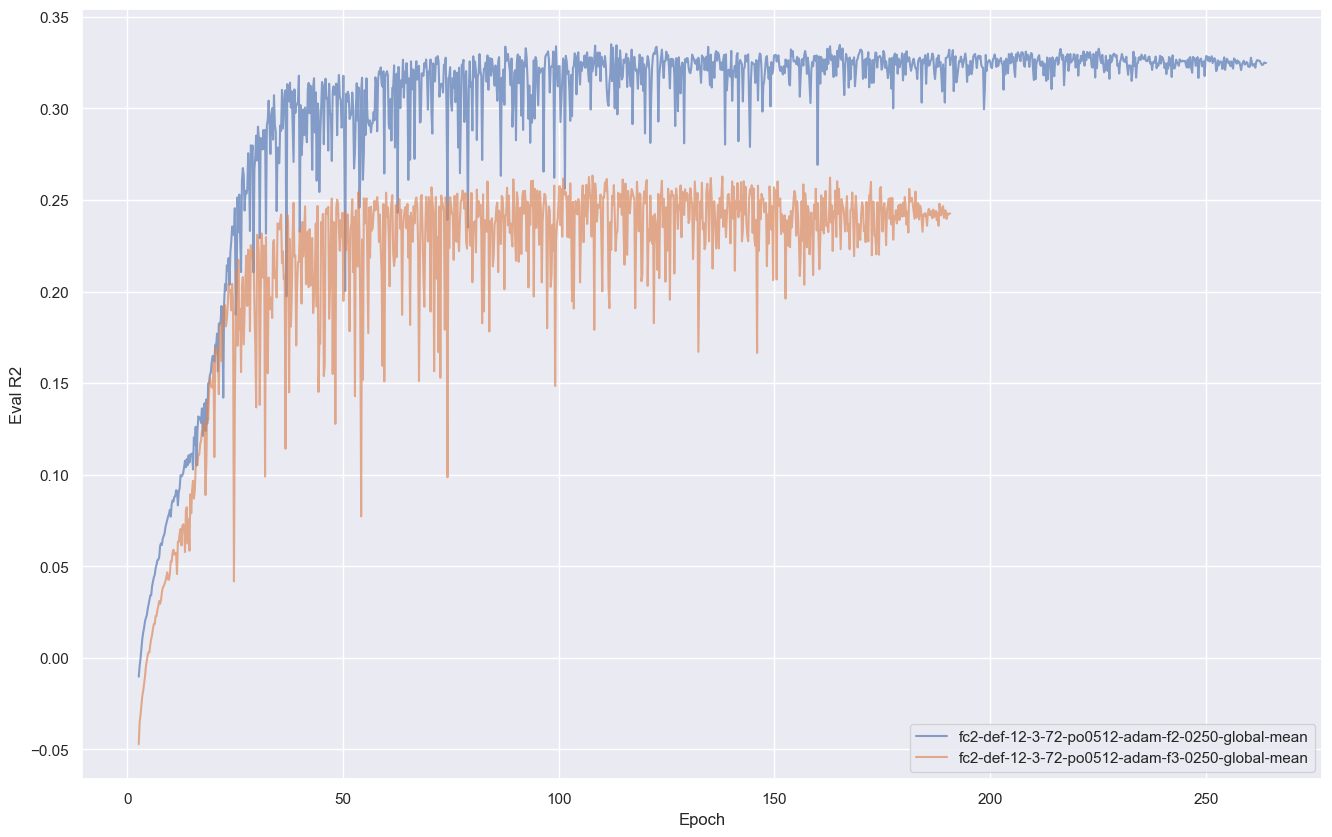

In [24]:
# Plot

report_plot.models_bert_r2(
	data = report_filter.filter_bert_reports(
		reports = report_bert_model,
		keep_only = [],
		drop_only = []
	),
	mode     = 'regression',
	x        = 12,
	y        = None,
	filename = None,
	step     = 'epoch'
)

### 3.1.2 Regression

In [25]:
# Concat reports and display top few

report = report_concat.concat_bert_reports(
	data      = report_bert_model,
	mode      = 'regression',
	metric    = 'eval_r2',
	ascending = False
)

if report is not None :
	report = report.head(n = 25)

report

,Mode,Arch,Type,Layer,Kmer,Feature,Filter,Sequence,Optimizer,Epochs,Target0,Target1,Target2,Eval_R2,Eval_ME,Eval_MAPE,Eval_MAE,Learning_Rate,Step,Epoch
0,regression,fc2,def,12,3,72,f2,po0512,adam,250,global,mean,None,0.33506,3.00240,1.61010,0.60534,0.00003,54400,112
1,regression,fc2,def,12,3,72,f3,po0512,adam,250,global,mean,None,0.26337,3.06501,0.30586,0.45235,0.00002,52300,107
